# Let's go further with my first Convolutional Neural Network

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

import cv2

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128 

## Load Data

In [4]:
%%time
from glob import glob
import os

imPath = "Paint_image/logo_drew/"
ls_path = glob(os.path.join(imPath, '*' ))

Wall time: 11 ms


In [5]:
%%time
name_to_label ={'tinder':[1,0],'messenger':[0,1]} #Pour labeliser facilement

data_base={'data': [], 'label' : [],'nom_label' :[],'image':[]}
for file in ls_path:                        #On parcours tous les fichiers                
    im = cv2.imread(file,0)                 #On charge l'image
  
    im=255-im                                #On inverse le contrast 
    
    #im = cv2.resize(im, (8, 8))             #On met au bon format de pixels
    name= file.split('\\')[1].split('_')[0] #On extrait le type
    
    data_aug = 1                             # Si on veut faire de la data_aug
    for i in range(data_aug):
        num_rows, num_cols = im.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), i*90, 1)
        im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
        data_base['data']+=[np.ndarray.flatten(im_rotation)]
        data_base['label']+=[name_to_label[name]]
        data_base['nom_label']+=[name]
        data_base['image']+=[im_rotation]
data_base['data']=np.array(data_base['data'])
data_base['label']=np.array(data_base['label'])
data_base['nom_label']=np.array(data_base['nom_label'])
data_base['image']=np.array(data_base['image'])

Wall time: 292 ms


In [6]:
data_base['image'].shape

(100, 64, 64)

In [7]:
# The number of pixels in each dimension of an image.
img_size = data_base['image'].shape[1]

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data_base['image'][1].size


# Tuple with height and width of images used to reshape arrays.
img_shape = data_base['image'][1].shape

# Number of classes, one class for each of 2 logo
num_classes = 2

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0},Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

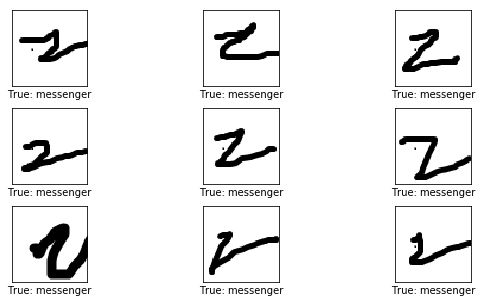

In [9]:
# Get the first images from the test-set.
images = data_base['image'][5:14]

# Get the true classes for those images.
cls_true = data_base['nom_label'][5:14]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [12]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [13]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [14]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [16]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [18]:
y_true_cls = tf.argmax(y_true, axis=1)

In [19]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [20]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

In [21]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [22]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 36) dtype=float32>

In [23]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [24]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 9216) dtype=float32>

In [25]:
num_features

9216

In [26]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [27]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [28]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [29]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 2) dtype=float32>

In [30]:
y_pred = tf.nn.softmax(layer_fc2)

In [31]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [32]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [33]:
cost = tf.reduce_mean(cross_entropy)

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [35]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [37]:
session = tf.Session()

In [38]:
session.run(tf.global_variables_initializer())

In [39]:
train_batch_size = 64

In [40]:
X= data_base['data']
Y= data_base['label']

In [41]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1,
                                                random_state=0)

C:\Users\Delanoue\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [42]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        #x_batch, y_true_batch, _ = data.random_batch(batch_size=train_batch_size)
        
        x_batch = Xtrain
        y_true_batch = ytrain

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [43]:
j={'[1 0]':0,'[0 1]':1}

In [44]:
feed_dict_test = {x: Xtest,
                  y_true: ytest,
                  y_true_cls: [j[str(a)] for a in ytest]}

In [45]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [46]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = feed_dict_test[y_true_cls]
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [47]:
dic={'[1 0]':0,'[0 1]':1}

In [56]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = Xtest.shape[0]

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = Xtest[i:j, :]

        # Get the associated labels.
        labels = ytest[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = [dic[str(a)] for a in ytest]

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [57]:
label_to_name ={0:'tinder',1:'messenger'}

In [66]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = np.tile(Xtest[incorrect],(9,1))
    
    # Get the predicted classes for those images.
    cls_pred = np.tile(cls_pred[incorrect],9)

    # Get the true classes for those images.
    cls_true = np.tile(np.array(feed_dict_test[y_true_cls])[incorrect],9)
    
    # Plot the first 9 images.
    print(cls_true[0:9])
    plot_images(images=images[0:9],
                cls_true=[label_to_name[a] for a in cls_true[0:9]],
                cls_pred=[label_to_name[a] for a in cls_pred[0:9]])

In [67]:
print_test_accuracy()

Accuracy on Test-Set: 100.0% (10 / 10)


In [68]:
optimize(num_iterations=1)

Time usage: 0:00:01


In [69]:
print_test_accuracy(show_example_errors=True)

Accuracy on Test-Set: 100.0% (10 / 10)
Example errors:
[]


AssertionError: 

In [ ]:
optimize(num_iterations=99) # We already performed 1 iteration above.

In [ ]:
print_test_accuracy(show_example_errors=True)

In [ ]:
optimize(num_iterations=900) # We performed 100 iterations above.

In [ ]:
print_test_accuracy(show_example_errors=True)